In [1]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets

from utils import *

In [2]:
# Load two real signals

sr = 44100
duration = 1.3
frames = np.arange(duration * sr) / sr

smooth_len = 1000
smoothing = np.linspace(0, 1, smooth_len)

A_signal, sr = librosa.load('sounds/real/A.wav', sr=44100, duration=duration)
A_signal[:smooth_len] *= smoothing
A_signal[-smooth_len:] *= np.flip(smoothing)
C_signal, _ = librosa.load('sounds/real/C.wav', sr=44100, duration=duration)
C_signal[:smooth_len] *= smoothing
C_signal[-smooth_len:] *= np.flip(smoothing)


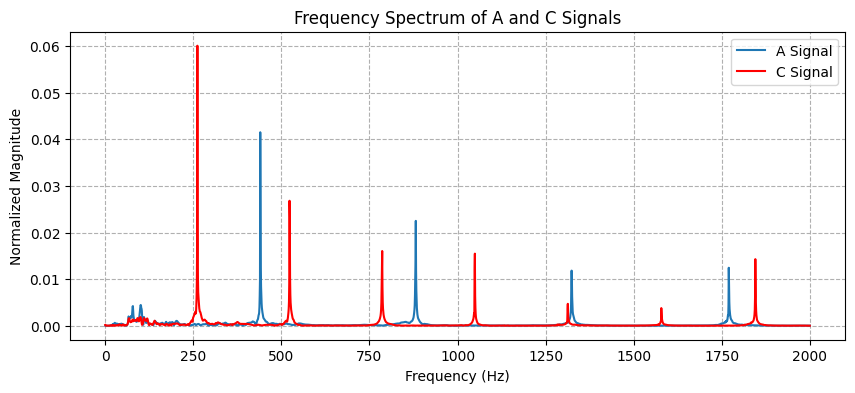

In [3]:
max_frequency_index = 2000 # in Hz, for plotting 

A_fft = np.fft.rfft(A_signal)
C_fft = np.fft.rfft(C_signal)
fft_frequency = np.fft.rfftfreq(len(A_signal), d=1/sr)

index = np.argmax(fft_frequency > max_frequency_index)

# Take the magnitude of the FFT and normalize it
A_fft_magnitude = np.abs(A_fft)[:index]
A_fft_magnitude /= np.sum(A_fft_magnitude)
C_fft_magnitude = np.abs(C_fft)[:index]
C_fft_magnitude /= np.sum(C_fft_magnitude)
fft_frequency = fft_frequency[:index]

plt.figure(figsize=[10, 4])

# Use line plots for a cleaner look
plt.plot(fft_frequency, A_fft_magnitude, label='A Signal', linewidth=1.5)
plt.plot(fft_frequency, C_fft_magnitude, label='C Signal', color='red', linewidth=1.5)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Normalized Magnitude')
plt.title('Frequency Spectrum of A and C Signals')
plt.grid(True, which="both", ls="--")
plt.legend()

plt.show()

In [4]:
M = cost_matrix(fft_frequency, A_fft_magnitude, C_fft_magnitude, itakura_saito, chi_2)


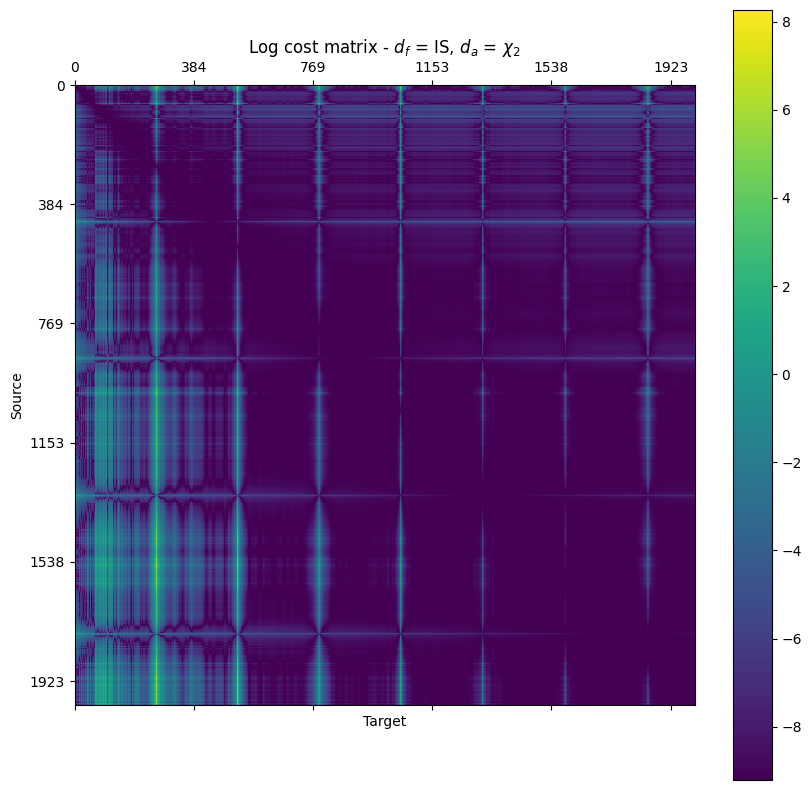

In [5]:
log_M = np.vectorize(log)(M + 0.0001)

fig, ax = plt.subplots(figsize=(10, 10))

ax.set_title("Log cost matrix - $d_f$ = IS, $d_a$ = $\chi_2$")
ax.set_xlabel("Target", fontsize=10)
ax.set_ylabel("Source", fontsize=10)

fft_frequency_int = [int(f) for f in fft_frequency] 
fft_index = 5

ax.set(xticks=np.arange(0, len(fft_frequency))[::fft_index], xticklabels=fft_frequency_int[::fft_index])
ax.set(yticks=np.arange(0, len(fft_frequency))[::fft_index], yticklabels=fft_frequency_int[::fft_index])
cax = ax.matshow(log_M, cmap='viridis')  # Use the colormap of your choice
fig.colorbar(cax)

In [7]:
# Optimal transport

alpha = 0.5

# EMD 

dirac_emd_interpolation, dirac_emd_plan = emd_custom_matrix(fft_frequency, A_fft_magnitude, C_fft_magnitude, itakura_saito, chi_2, alpha=alpha)


/Users/davidvaldivia/IASD/memoire/audio_ot/audio_1D_transport/.venv/lib/python3.9/site-packages/ot/lp/__init__.py:354: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


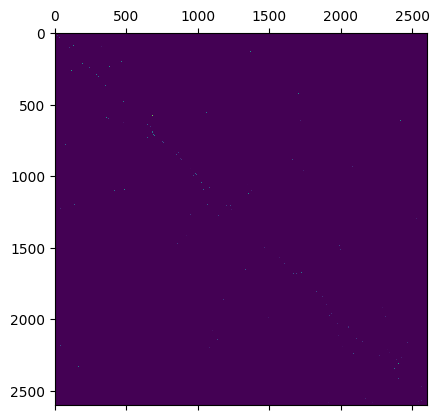

In [8]:
log_plan = np.vectorize(log)(dirac_emd_plan + 1e-5)

plt.matshow(log_plan)

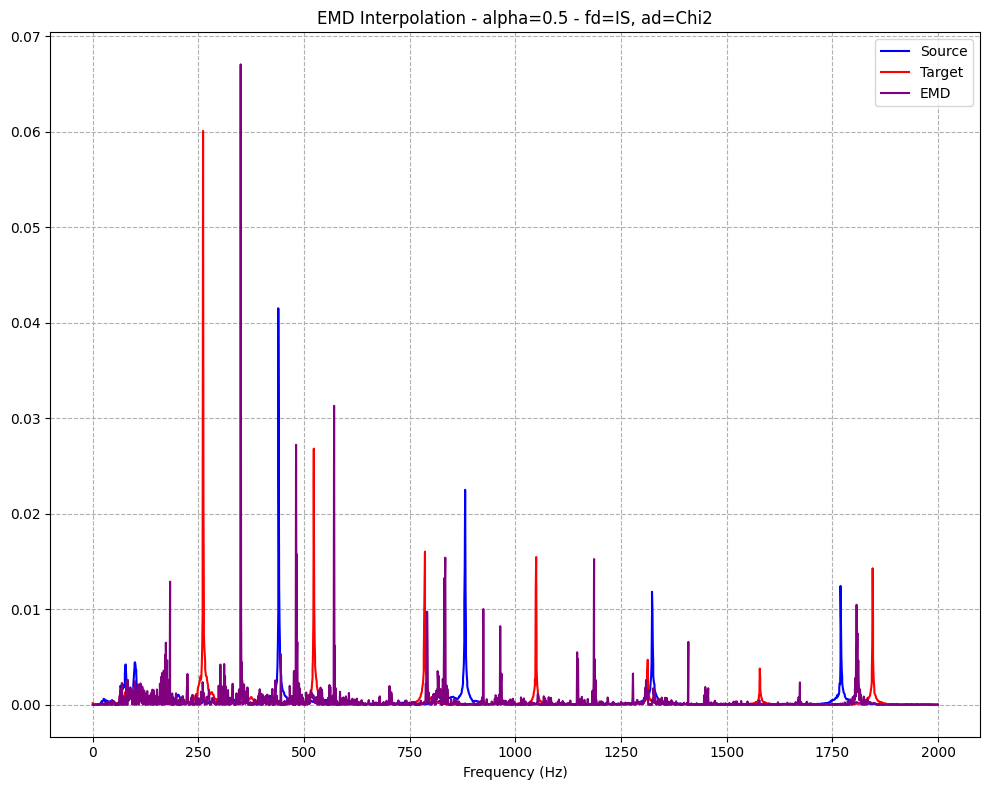

In [40]:
plt.figure(figsize=[10, 8])  # Increase figure size to accommodate both subplots

# Second subplot for A, C, and EMD interpolation
plt.plot(fft_frequency_int, A_fft_magnitude, label=f"Source", color='blue', linewidth=1.5)
plt.plot(fft_frequency_int, C_fft_magnitude, label=f"Target", color='red', linewidth=1.5)
plt.plot(fft_frequency_int, dirac_emd_interpolation, label='EMD', color="purple")
plt.xlabel('Frequency (Hz)')
plt.title(f'EMD Interpolation - alpha={alpha} - fd=IS, ad=Chi2')
plt.grid(True, which="both", ls="--")
plt.legend()

plt.tight_layout()  # Adjust the layout so the plots are neatly arranged
plt.show()

In [15]:
dirac_emd_interpolation_pad = np.pad(dirac_emd_interpolation, (0, len(A_fft) - len(dirac_emd_interpolation)), 'constant')

fft_emd_inversed = invert_magnitude_fft(dirac_emd_interpolation_pad, A_fft, C_fft, alpha)

fft_signals = [A_signal, C_signal, fft_emd_inversed]

fft_titles = ['A', 'C', f'EMD - alpha={alpha}']
audio_widgets = [audio_widget(signal, title) for signal, title in zip(fft_signals, fft_titles)]

grid = widgets.VBox(audio_widgets)
grid

/Users/davidvaldivia/IASD/memoire/audio_ot/audio_1D_transport/utils.py:110: ComplexWarning: Casting complex values to real discards the imaginary part
  complex_spectrum[i] += (1 - alpha) * source[i] / np.abs(source[i])
/Users/davidvaldivia/IASD/memoire/audio_ot/audio_1D_transport/utils.py:112: ComplexWarning: Casting complex values to real discards the imaginary part
  complex_spectrum[i] += alpha * target[i] / np.abs(target[i])


/Users/davidvaldivia/IASD/memoire/audio_ot/audio_1D_transport/.venv/lib/python3.9/site-packages/IPython/lib/display.py:172: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)


MovieWriter ffmpeg unavailable; using Pillow instead.


frequency function: IS
amp function: Chi2


/Users/davidvaldivia/IASD/memoire/audio_ot/audio_1D_transport/.venv/lib/python3.9/site-packages/ot/lp/__init__.py:354: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


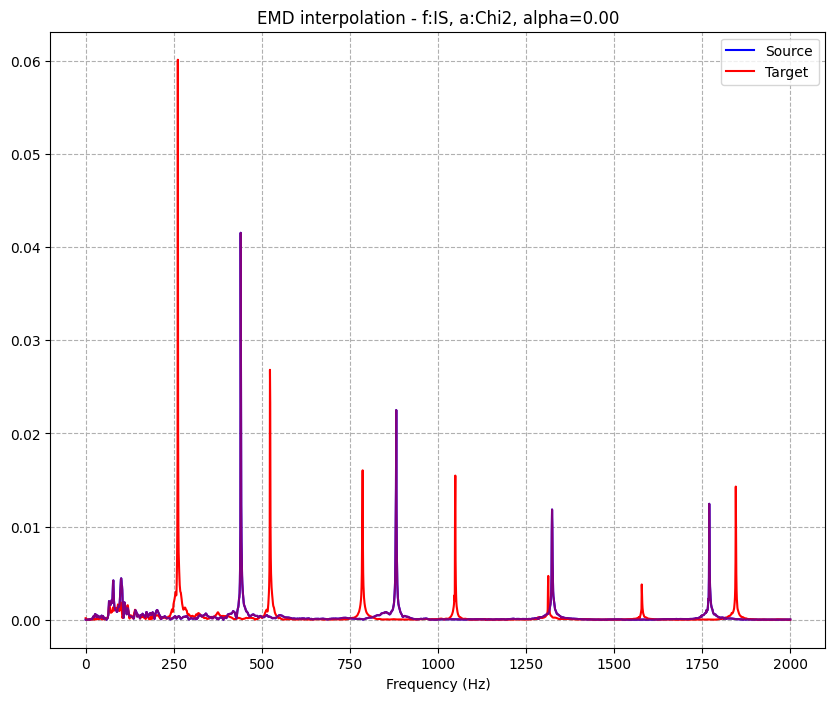

In [12]:
import matplotlib.animation as animation

# Setup figure and axes for the plot
fig, ax = plt.subplots(figsize=[10, 8])

# Static plots for A and C
ax.plot(fft_frequency, A_fft_magnitude, label='Source', color='blue', linewidth=1.5)
ax.plot(fft_frequency, C_fft_magnitude, label='Target', color='red', linewidth=1.5)
ax.set(xlabel='Frequency (Hz)', title=f'EMD interpolation - f:IS, a:Chi2')
ax.grid(True, which="both", ls="--")
ax.legend()

emd_line, = ax.plot([], [], label='Interpolation', color="purple")

def update(frame):
    alpha = frame / 20.0  # Assuming 40 frames to go from 0 to 1
    
    interpolation, _ = emd_custom_matrix(fft_frequency, A_fft_magnitude, C_fft_magnitude, itakura_saito, chi_2, alpha=alpha)

    emd_line.set_data(fft_frequency, interpolation)
    
    ax.set_title(f'EMD interpolation - f:IS, a:Chi2, alpha={alpha:.2f}')
    
    return emd_line,

# Create animation
ani = animation.FuncAnimation(fig=fig, func=update, frames=np.arange(0, 21), interval=100)

# Save the animation
ani.save(f'animations/matrix_exp/real/emd_IS_Chi2.gif')

# STFTs

In [16]:
from math import log2, ceil

window_size = 20 # ms
window_size_samples = window_size * 1e-3 * sr
n_fft = 2 ** ceil(log2(window_size_samples))
A_stft = librosa.stft(A_signal, n_fft=n_fft)
C_stft = librosa.stft(C_signal, n_fft=n_fft)

stft_frequency = librosa.fft_frequencies(sr=sr, n_fft=n_fft)

In [18]:
# Optimal transport

alpha = 0.5
n_frames = A_stft.shape[1]

stft_emd_interpolation = np.zeros_like(A_stft)

for frame in range(n_frames):

    A_frame, A_frame_relative_amplitude = normalized_frame(A_stft, frame)
    C_frame, C_frame_relative_amplitude = normalized_frame(C_stft, frame)

    interpolated_frame_relative_amplitude = (1-alpha) * A_frame_relative_amplitude + alpha * C_frame_relative_amplitude


    stft_emd_interpolation[:, frame], _ = emd_custom_matrix(stft_frequency, A_frame, C_frame, itakura_saito, chi_2, alpha=alpha)
    stft_emd_interpolation[:, frame] *= interpolated_frame_relative_amplitude


/var/folders/3q/fky9tlbn3_qfz7hw6cxpgdv40000gp/T/ipykernel_5369/1225127891.py:6: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  img = librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max),


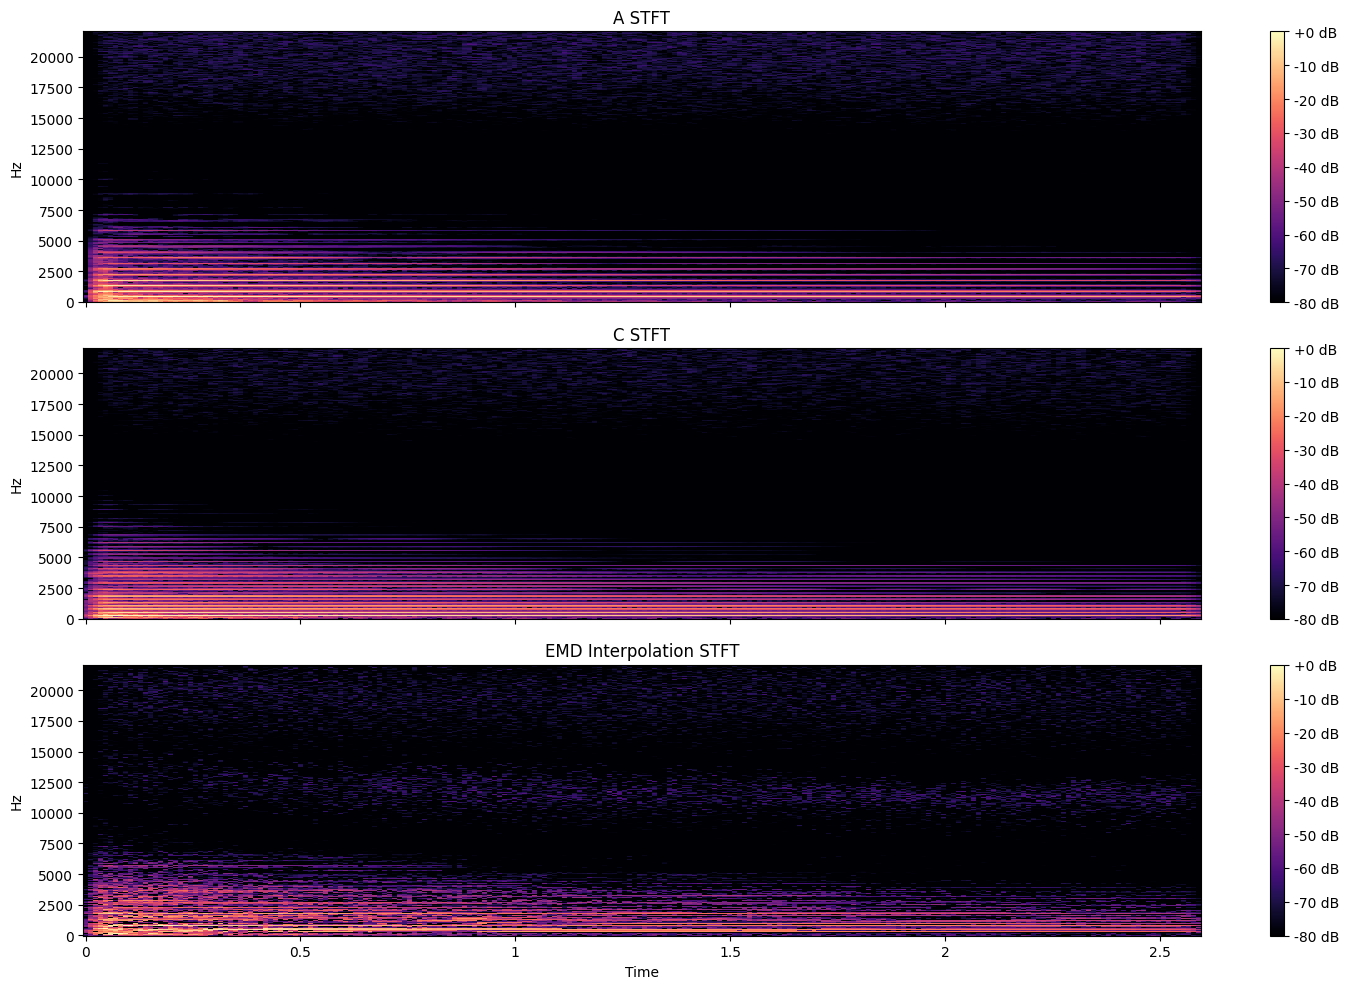

In [20]:
fig, axs = plt.subplots(3, 1, figsize=(15, 10), sharex=True, sharey=True)
titles = ['A STFT', 'C STFT', 'EMD Interpolation STFT']
spectrograms = [A_stft, C_stft, stft_emd_interpolation]

for ax, spectrogram, title in zip(axs.flatten(), spectrograms, titles):
    img = librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max),
                                   ax=ax,
                                   x_axis='time',
                                   y_axis='hz',
                                   sr=sr)
    ax.set_title(title)
    ax.label_outer()
    fig.colorbar(img, ax=ax, format="%+2.0f dB")

plt.tight_layout()
plt.show()


In [21]:
stft_emd_inversed = librosa.griffinlim(stft_emd_interpolation, n_iter=100)

fft_signals = [A_signal, C_signal, stft_emd_inversed]
fft_titles = ['A', 'C', f'EMD interpolation - alpha={alpha}']
audio_widgets = [audio_widget(signal, title) for signal, title in zip(fft_signals, fft_titles)]

grid = widgets.VBox(audio_widgets)
grid

/Users/davidvaldivia/IASD/memoire/audio_ot/audio_1D_transport/.venv/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/davidvaldivia/IASD/memoire/audio_ot/audio_1D_transport/.venv/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


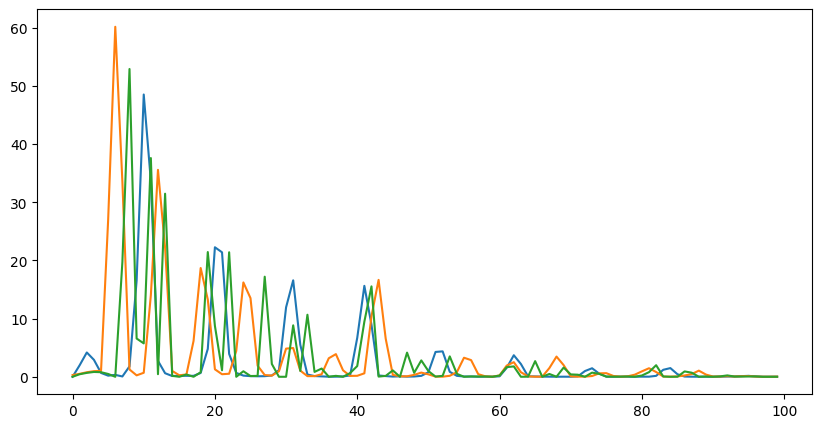

In [52]:
plt.figure(figsize=(10, 5))
plt.plot(np.abs(A_stft[:, 50][:100]))
plt.plot(np.abs(C_stft[:, 50][:100]))
plt.plot(stft_emd_interpolation[:, 50][:100])

In [44]:
np.sum(np.abs(di))

75.407555